Sd: min=51.0143325058444, max=270.29496991297424, mean=200.59859505441574, median=201.099914934048
b: min=1108.073507275341, max=1299.8305018188632, mean=1168.7042253948416, median=1168.7413557631803
Smax: min=3910.9036067814227, max=8690.896901586406, mean=4326.292568753984, median=4345.448451979358
smooth: min=0.0032162226270884275, max=1.0, mean=0.036555737257003784, median=0.0032162226270884275


/var/folders/gx/4gwwyrv10n9f3d2zmm71n9pm0000gq/T/ipykernel_29752/1484706178.py:16: RuntimeWarning: overflow encountered in exp
  return Smax - (Smax - (Sd * t + b)) / (1 + np.exp(smoothness * ((Sd * t + b) - Smax)))


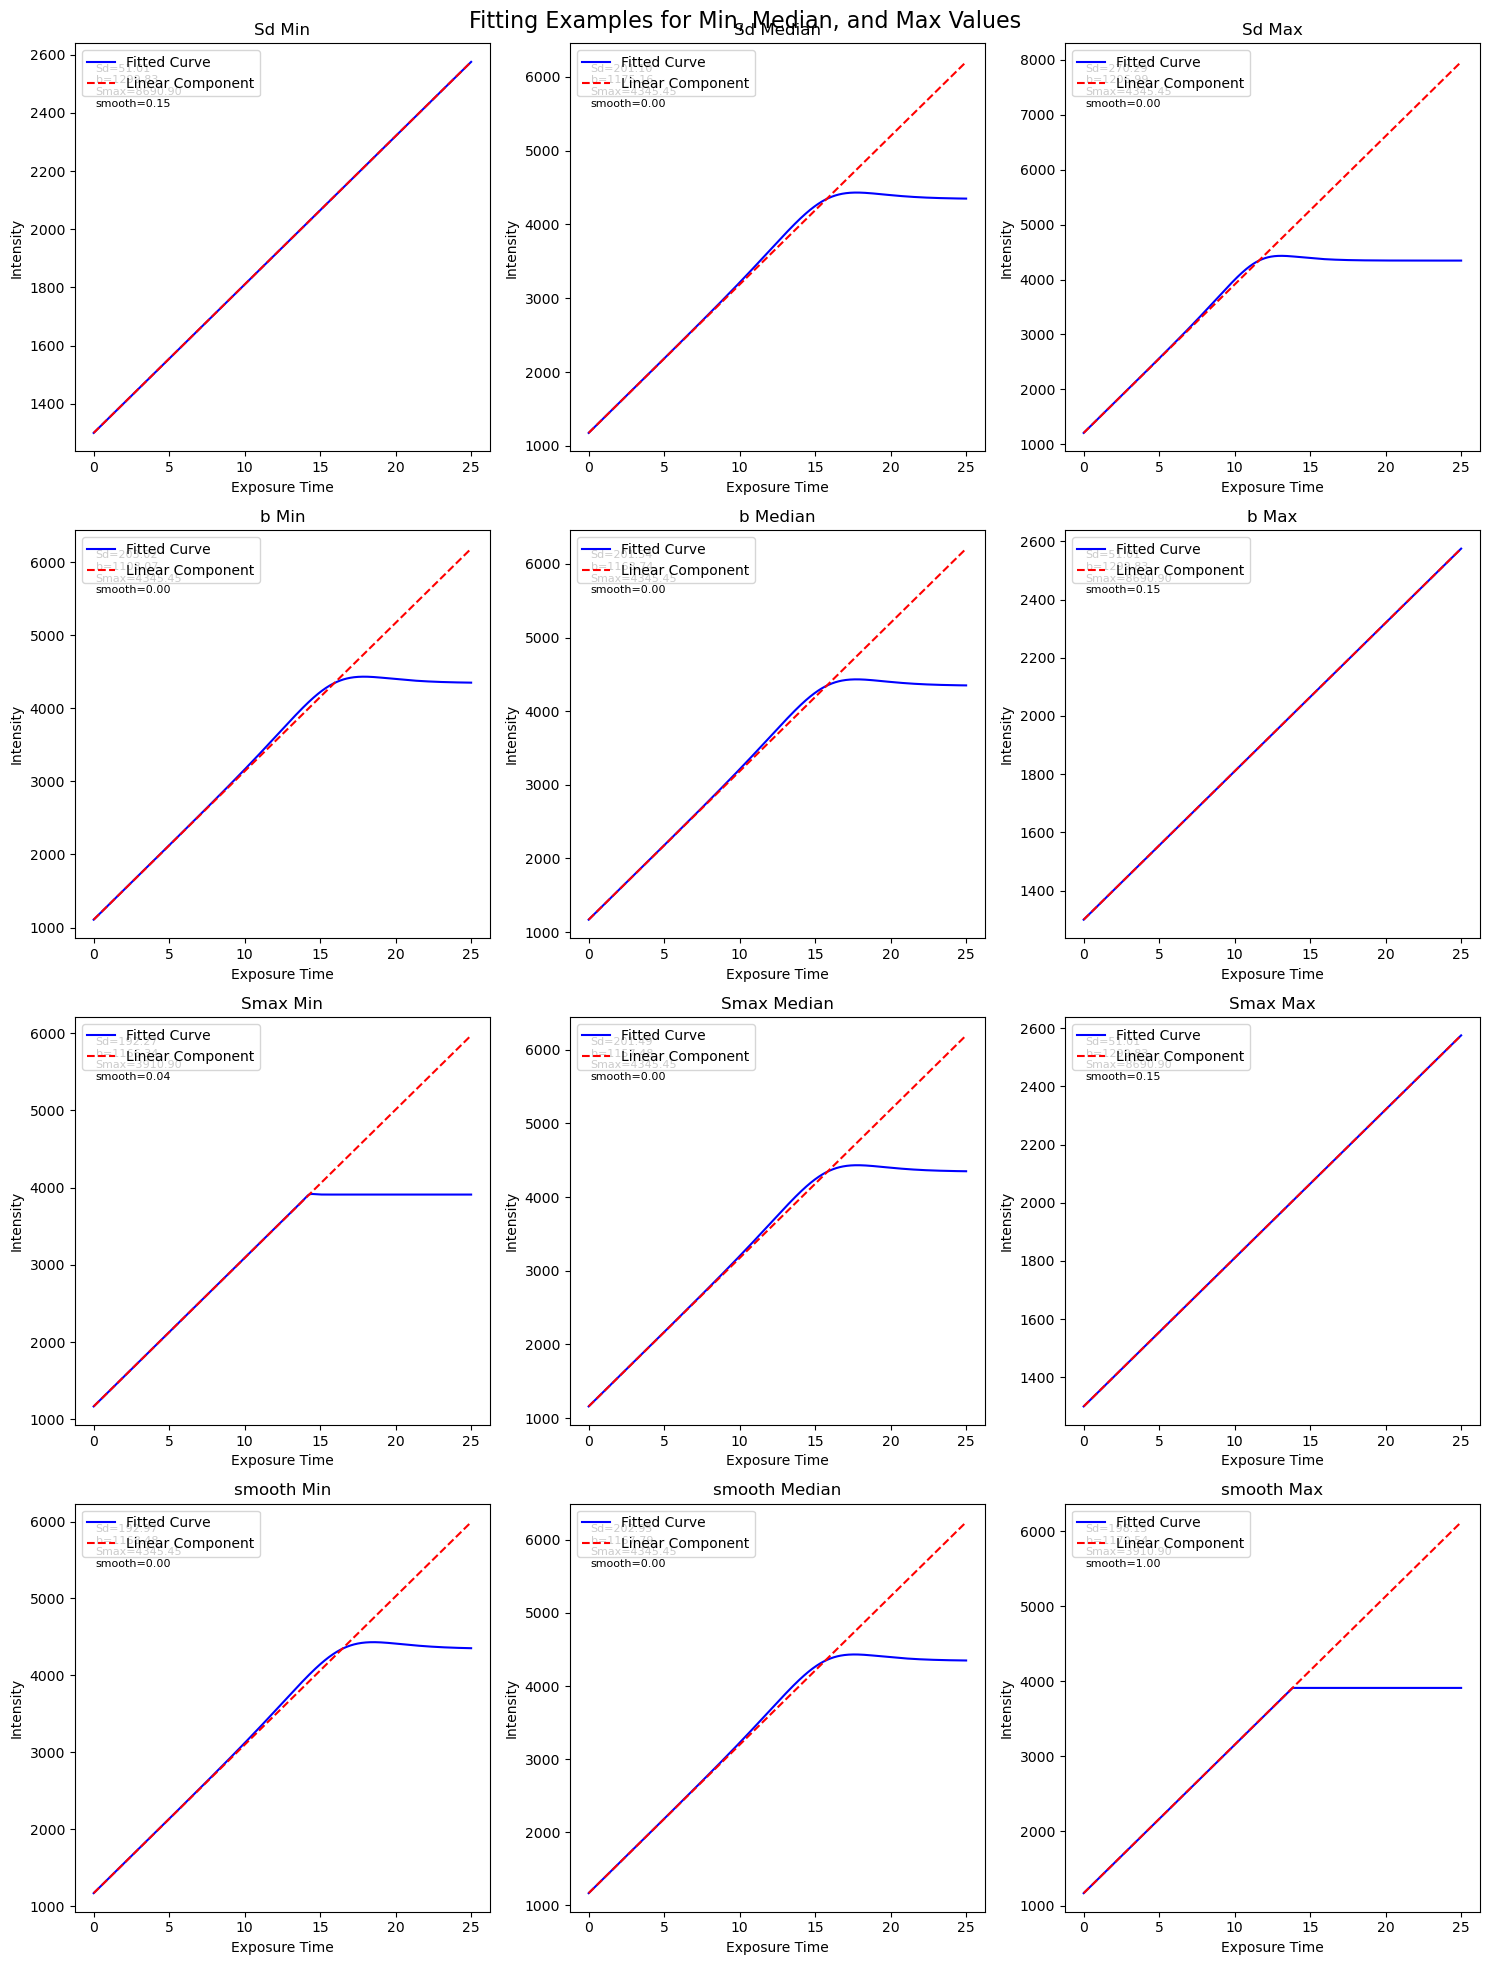

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import h5py

# Function to load the arrays
def load_arrays(directory):
    Sd = np.load(f"{directory}/Sd.npy")
    b = np.load(f"{directory}/b.npy")
    Smax = np.load(f"{directory}/Smax.npy")
    smooth = np.load(f"{directory}/smooth.npy")
    return Sd, b, Smax, smooth

# Function for the asymptotic fit
def asymptotic_fit(t, Smax, smoothness, Sd, b):
    return Smax - (Smax - (Sd * t + b)) / (1 + np.exp(smoothness * ((Sd * t + b) - Smax)))

# Load the arrays
directory = "./data"  # Replace with your directory path
Sd, b, Smax, smooth = load_arrays(directory)

# Load original darkcount data and exposure times
# Replace 'your_darkcount_file.h5' with the actual filename
with h5py.File(f"{directory}/your_darkcount_file.h5", 'r') as f:
    darkcount_data = f['Cube']['Images'][()]
    exposure_times = f['Cube']['TimeExposure'][()]

# Print basic statistics for each array
for name, arr in zip(['Sd', 'b', 'Smax', 'smooth'], [Sd, b, Smax, smooth]):
    print(f"{name}: min={np.min(arr)}, max={np.max(arr)}, mean={np.mean(arr)}, median={np.median(arr)}")

# Function to get min, median, and max indices
def get_min_median_max_indices(arr):
    flat_arr = arr.flatten()
    return np.argmin(flat_arr), np.argsort(flat_arr)[len(flat_arr)//2], np.argmax(flat_arr)

# Get indices for each array
indices = {
    'Sd': get_min_median_max_indices(Sd),
    'b': get_min_median_max_indices(b),
    'Smax': get_min_median_max_indices(Smax),
    'smooth': get_min_median_max_indices(smooth)
}

# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle("Fitting Examples for Min, Median, and Max Values", fontsize=16)

# Generate example exposure times for smooth curve
smooth_times = np.linspace(0, np.max(exposure_times), 1000)

# Plot for each array
for i, (name, idx) in enumerate(indices.items()):
    for j, (label, index) in enumerate(zip(['Min', 'Median', 'Max'], idx)):
        sd, b_, smax, sm = Sd.flatten()[index], b.flatten()[index], Smax.flatten()[index], smooth.flatten()[index]
        y = asymptotic_fit(smooth_times, smax, sm, sd, b_)
        
        # Get actual data for this pixel
        pixel_data = darkcount_data[:, index // darkcount_data.shape[2], index % darkcount_data.shape[2]]
        
        axs[i, j].plot(smooth_times, y, 'b-', label='Fitted Curve')
        axs[i, j].plot(smooth_times, sd * smooth_times + b_, 'r--', label='Linear Component')
        axs[i, j].scatter(exposure_times, pixel_data, c='g', marker='o', label='Actual Data')
        axs[i, j].set_title(f"{name} {label}")
        axs[i, j].set_xlabel("Exposure Time")
        axs[i, j].set_ylabel("Intensity")
        axs[i, j].legend()
        axs[i, j].text(0.05, 0.95, f"Sd={sd:.2f}\nb={b_:.2f}\nSmax={smax:.2f}\nsmooth={sm:.2f}",
                       transform=axs[i, j].transAxes, verticalalignment='top', fontsize=8)

plt.tight_layout()
plt.show()

# Optional: Save the figure
# plt.savefig('fitting_examples_with_data.png', dpi=300, bbox_inches='tight')